In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Helper Functions

In [34]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [35]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [36]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [37]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [38]:
# set train and test data

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 10
noise = 0

if noise:
    temp_train = add_noise(temp_train, noise_scale)

x_train = temp_train
x_test = temp_test
y_train = spectrum_train
y_test = spectrum_test

In [39]:
# create input and output tensors for the forward model
x = df_to_tensor(x_train)
y = df_to_tensor(y_train)

In [40]:
n_samples, middle_size = x.shape
_, io_size = y.shape
# middle_size = 66, io_size = 11
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')

x shape: torch.Size([2000, 11])
y shape: torch.Size([2000, 66])


# Design Model 

### Forward Model — middle_size to i/o_size

In [41]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = self.lin_fin(output)
        return output

In [42]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size, out_transform=nn.Sigmoid()):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.out = nn.Linear(30, middle_size)
        self.out_transform = out_transform

    def forward(self, y):
        h = F.leaky_relu(self.lin1(y))
        h = F.leaky_relu(self.lin2(h))
        o = self.out(h)
        if self.out_transform:
            o = self.out_transform(o)
        return o

In [43]:
class TandemNet(nn.Module):

    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, y):
        '''
        Args:
            y: true CIE coordinates
        
        Returns:
            x_: predicted structural parameters
            y_: predicted CIE coordinates for the inversely-designed structure

        '''
        pred_temp = self.inverse_model(y)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [44]:
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)
# print(type(inverse_model(x)))
print(forward_model(inverse_model(y)))
print(tandem_net(y))

tensor([[-0.0572, -0.0555, -0.2200,  ...,  0.1302,  0.1024,  0.0036],
        [-0.0570, -0.0555, -0.2199,  ...,  0.1303,  0.1027,  0.0033],
        [-0.0576, -0.0555, -0.2204,  ...,  0.1298,  0.1012,  0.0041],
        ...,
        [-0.0574, -0.0555, -0.2202,  ...,  0.1301,  0.1020,  0.0037],
        [-0.0571, -0.0555, -0.2199,  ...,  0.1303,  0.1025,  0.0035],
        [-0.0573, -0.0555, -0.2198,  ...,  0.1302,  0.1025,  0.0034]],
       grad_fn=<AddmmBackward0>)
(tensor([[0.5232, 0.4247, 0.4662,  ..., 0.5074, 0.5174, 0.4864],
        [0.5227, 0.4255, 0.4664,  ..., 0.5052, 0.5135, 0.4885],
        [0.5233, 0.4192, 0.4640,  ..., 0.5147, 0.5303, 0.4786],
        ...,
        [0.5239, 0.4230, 0.4649,  ..., 0.5101, 0.5221, 0.4842],
        [0.5230, 0.4250, 0.4664,  ..., 0.5065, 0.5158, 0.4872],
        [0.5244, 0.4250, 0.4665,  ..., 0.5063, 0.5157, 0.4877]],
       grad_fn=<SigmoidBackward0>), tensor([[-0.0572, -0.0555, -0.2200,  ...,  0.1302,  0.1024,  0.0036],
        [-0.0570, -0.0555, -

# Construct Loss and Optimizer

In [45]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer_forward = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)
optimizer_tandem = torch.optim.Rprop(inverse_model.parameters(), lr=learning_rate)

# Training Loop

In [46]:
def train_forward_model(forward_model, x, y):

    forward_loss_list = []
    num_forward_epochs = 1000

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        y_predicted = forward_model(x)
        loss = criterion(y_predicted, y)
        forward_loss_list.append(loss.item())

        # backward pass
        loss.backward()

        # update
        optimizer_forward.step()

        # empty gradients
        optimizer_forward.zero_grad()

        if (epoch+1) % int(num_forward_epochs/10) == 0:
            print(f'forward epoch: {epoch+1}, forward loss = {loss:.4f}')

    return num_forward_epochs, forward_loss_list

In [47]:
def train_tandem_model(inverse_model, forward_model, y):

    tandem_loss_list = []
    num_tandem_epochs = 1000

    for epoch in range(num_tandem_epochs):
        # forward pass and loss
        x_predicted = inverse_model(y)
        y_predicted = forward_model(x_predicted)
        loss = criterion(y_predicted, y)
        tandem_loss_list.append(loss.item())

        # backward pass
        loss.backward()

        # update
        optimizer_tandem.step()

        # empty gradients
        optimizer_tandem.zero_grad()

        if (epoch+1) % int(num_tandem_epochs/10) == 0:
            print(f'tandem epoch: {epoch+1}, tandem loss = {loss:.4f}')

    return num_tandem_epochs, tandem_loss_list

In [48]:
num_forward_epochs, forward_loss_list = train_forward_model(forward_model, x, y)
num_tandem_epochs, tandem_loss_list = train_tandem_model(inverse_model, forward_model, y)

forward epoch: 100, forward loss = 0.0742
forward epoch: 200, forward loss = 0.0575
forward epoch: 300, forward loss = 0.0456
forward epoch: 400, forward loss = 0.0352
forward epoch: 500, forward loss = 0.0284
forward epoch: 600, forward loss = 0.0223
forward epoch: 700, forward loss = 0.0178
forward epoch: 800, forward loss = 0.0136
forward epoch: 900, forward loss = 0.0096
forward epoch: 1000, forward loss = 0.0074


TypeError: train_tandem_model() takes 3 positional arguments but 4 were given

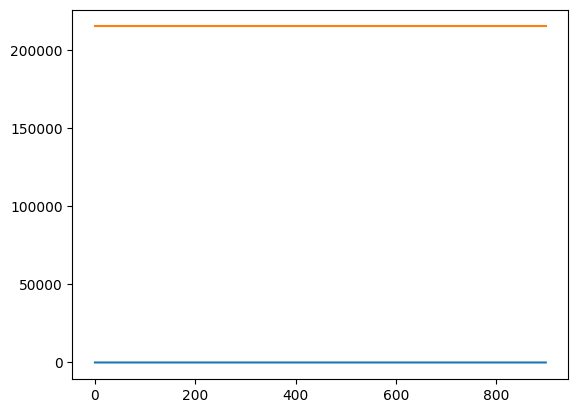

In [ ]:
# plot forward and inverse loss
plt.plot(forward_loss_list[100:num_forward_epochs])
plt.plot(tandem_loss_list[100:num_tandem_epochs])

# Plots

### Clean

In [ ]:
# pred = tandem_net(df_to_tensor(y_test))
# pred = pd.DataFrame(pred.numpy())
# actual = y_test

In [ ]:
# import matplotlib.pyplot as plt
# import random

# def plot_actual_vs_pred(index):
#     actual_np = actual.values[index]
#     pred_np = pred.values[index]


#     plt.plot(y_train.columns, actual_np, label='actual')
#     plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

#     if direction:
#         plt.title("Temperature to Spectrum")
#         plt.xlabel("Wavlength")
#         plt.ylabel("Intensity")
#     else:
#         plt.title("Spectrum to Temperature")
#         plt.xlabel("Layer")
#         plt.ylabel("Temperature (K)")

#     plt.legend()
#     plt.show()

In [ ]:
# for index in range(10):
#     plot_actual_vs_pred(index*10)